In [334]:
import pandas as pd
import numpy as np
import pytz
from typing import Tuple
import pvlib
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Business Understanding
We kijken naar zonnepaneeldata over een periode van net iets minder naar twee jaar. De metingen bestaan uit het wattage dat elke minuut door de panelen werd opgewekt. Hierbij is de data al omgezet naar watt per vierkante meter.

We zijn op zoek naar de efficientie van de panelen. Deze kan berekend worden door de theoretische hoeveelheid opbrengst te nemen en deze te verlagen met een bepaalde factor om de werkelijke meting te benaderen. Deze factor is de efficientie.

Om deze berekening te moeten doen, maken we gebruik van de pvlib library. Hierbij is het nodig om de helling van het zonnepaneel met het dak te weten (de tilt). En ook de richting van het paneel (de azimuth). De azimuth loopt van 0 graden noord, naar 90 graden oost, naar 180 graden zuid en dan naar 270 graden west.

# Data Understanding
### Uitleg van de Kolommen in de Zonnepaneel- en Weerdata
| Kolom      | Beschrijving                                                                 |
|------------|------------------------------------------------------------------------------|
| production | De hoeveelheid elektriciteit geproduceerd door de zonnepanelen (W/m²)        |
| T          | De temperatuur op het moment van de meting, meestal in graden Celsius        |
| FH         | Gemiddelde windsnelheid per uur, gemeten in tienden van meters per seconde (m/s) |
| DD         | Windrichting, aangegeven in graden (0° = Noord, 90° = Oost, etc.)            |
| Q          | Globale zonne-instraling, gemeten in watt per vierkante meter (W/m²)         |
| DR         | Neerslagduur per uur, gemeten in tienden van een uur                         |
| RH         | Relatieve luchtvochtigheid, uitgedrukt als percentage (%)                    |
| U          | Windsnelheid, meestal in meters per seconde (m/s)                            |
| N          | Bewolking, mogelijk aangegeven in een schaal van 0 tot 10                    |

bron: https://pypi.org/project/historicdutchweather/

### Stroomproductiedata ophalen
Laad de zonnepaneeldata en verken de structuur van de dataset. Controleer op ontbrekende waarden en controleer de datatypes voor verdere analyse.

In [335]:
## Laad en verken de zonnepaneeldata
solar_df = pd.read_csv('../../bijlagen/dataset.csv')
solar_df['time'] = pd.to_datetime(solar_df['time'])
solar_df = solar_df.set_index('time')

# Verken de zonnepaneeldata
print(solar_df.isna().sum())  # Controleer op ontbrekende waarden
print(solar_df.dtypes)        # Controleer de datatypes
print(solar_df.shape)         # Bekijk de afmetingen van de dataset
print(solar_df.describe().transpose())  # Beschrijvende statistieken van de dataset

production    0
dtype: int64
production    float64
dtype: object
(1266008, 1)
                count       mean        std  min  25%  50%   75%          max
production  1266008.0  21.812874  77.228418  0.0  0.0  0.0  20.0  2206.666667


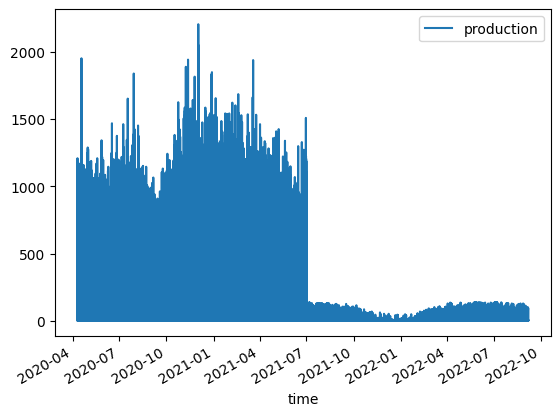

In [336]:
# Visualiseer de zonnepaneeldata
plot = solar_df.plot()

## Data Verkenning en Observaties

Na inspectie blijkt er geen ontbrekende waarden te zijn, maar er zijn aanzienlijke pieken in de productie. Ook is er een merkbare daling in de productie na juli/augustus.

## Weerdataset ophalen
Voer vergelijkbare stappen uit voor de weerdata. Zet de 'tijd'-kolom om naar datetime-formaat en filter op relevante kolommen.

In [352]:
## Laad de weersdata in
weather_df = pd.read_csv('../../bijlagen/weather.csv')
weather_df['Unnamed: 0'] = pd.to_datetime(weather_df['Unnamed: 0'])
weather_df = weather_df.rename(columns={'Unnamed: 0': 'time'})
weather_df = weather_df.set_index('time')

In [353]:
# Beperk tot de bewolkingskolom
weather_df = weather_df[['N']]

In [354]:
# Verken de weerdata
print(weather_df.isna().sum())  # Controleer op ontbrekende waarden
print(weather_df.describe().transpose())  # Beschrijvende statistieken van de weerdata

N    71
dtype: int64
     count     mean       std            min       25%       50%  75%  max
N  21025.0  5.82491  2.836864  1.867937e-317  3.964266  7.543686  8.0  9.0


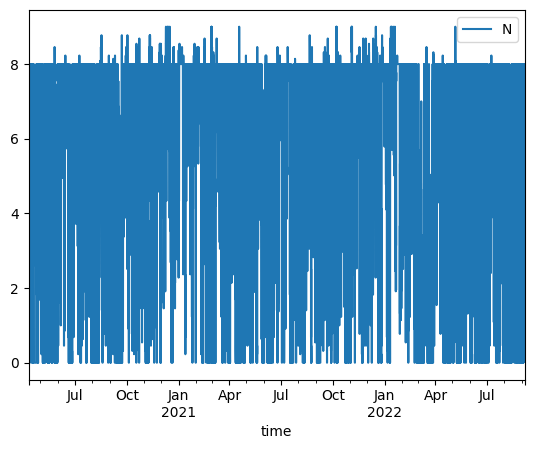

In [355]:
# Visualiseer de weerdata
plot = weather_df.plot()

## Data Preparation
De data wordt vervolgens geresampled naar intervallen van 10 minuten. Dit helpt om de ruis in de data te verminderen en maakt verdere analyses efficiënter.

In [357]:
## Resample de zonnepaneeldata naar 10 minuten
resampled_solar_10min = solar_df.loc[weather_df.index[0]:weather_df.index[-1]]
resampled_solar_10min = resampled_solar_10min.resample('10min', origin=resampled_solar_10min.index[0]).median()
resampled_solar_10min[resampled_solar_10min['production'] > 200] = 50  # Verwijder outliers

In [358]:
## Combineer zonnepaneel- en weersdata
combined_df = pd.DataFrame({'production': resampled_solar_10min['production'], 'weer': weather_df['N']})
combined_df['weer'] = combined_df['weer'].astype(float).interpolate(method='time')
combined_df = combined_df[combined_df['production'].notna()]

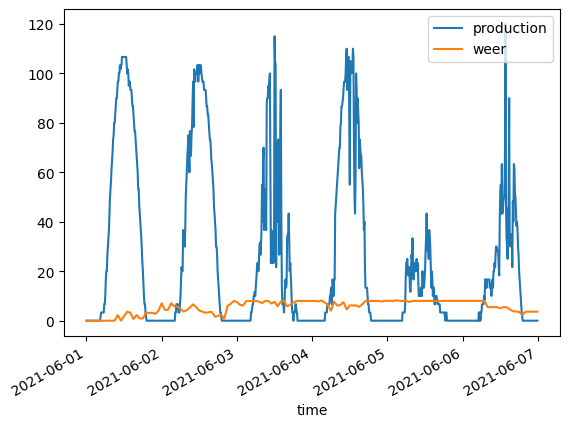

In [359]:
# Visualiseer een deel van de gecombineerde data
plot = combined_df.loc['06-01-2021':'06-06-2021'].plot()

### Opmerkingen over dataobservatie 
Er zijn duidelijke patronen van nacht en bewolking zichtbaar. Opmerkelijke afwijkingen kunnen wijzen op andere invloeden zoals de dikte van de bewolking.

# Modeling

In [360]:
def model_zonnestraling(tilt:float, azimuth:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame: # type: ignore
    """Berekent de hoeveelheid stroom die een paneel maximaal produceert met 100% efficientie"""

    zonne_positie_aan_hemel = pvlib.solarposition.get_solarposition(tijdsreeks, lat, lon)

    #locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'Europe/Amsterdam'))
    locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'UTC')) # type: ignore
    heldere_hemel = locatie.get_clearsky(tijdsreeks)

    instraling = pvlib.irradiance.get_total_irradiance(tilt,
                                                       azimuth,
                                                       zonne_positie_aan_hemel['zenith'],
                                                       zonne_positie_aan_hemel['azimuth'],
                                                       heldere_hemel.dni, # type: ignore
                                                       heldere_hemel.ghi, # type: ignore
                                                       heldere_hemel.dhi) # type: ignore

    return instraling['poa_global'].to_frame().rename(columns={'poa_global':'zonlicht'})

In [361]:
def model_paneel(tilt: float, azimuth: float, efficiëntie: float, tijdsreeks: pd.core.indexes.datetimes.DatetimeIndex, lat: float, lon: float) -> pd.DataFrame: # type: ignore
    """Bereken de hoeveelheid geabsorbeerd zonlicht op een paneel op basis van de efficiëntie"""

    # Verkrijg de zonne-instraling en pas de efficiëntie toe
    return model_zonnestraling(tilt, azimuth, tijdsreeks, lat, lon) * efficiëntie


In [362]:
def loss(params: Tuple[float, float, float], df: pd.DataFrame, lat: float, lon: float) -> float:
    """Bereken de Mean Squared Error tussen de waargenomen en berekende zonne-instraling."""

    (tilt, azimuth, efficientie) = params

    # Haal de tijdsreeks op uit de waarnemingen
    tijdsreeks = df.index

    # Verkrijg de voorspelde zonne-instraling met model_paneel
    df_model = model_paneel(tilt, azimuth, efficientie, tijdsreeks, lat, lon)

    return np.sum((df_model['zonlicht'] - df['production'])**2)

## Model Optimaliseren
De modellen worden geoptimaliseerd door de efficiëntie, tilt, en azimuth te variëren om de beste match te vinden tussen modelvoorspellingen en werkelijke data.

In [363]:
# Definieer de locatie van Zwolle, NL
lat = 52.5167
lon = 6.0833

# Eerste inschatting
tilt = 35
azimuth = 180
efficientie = 0.2

In [364]:
# Filter datasets op basis van bewolking
filtered_data_1 = combined_df[combined_df['weer'] < 1]
filtered_data_2 = combined_df[combined_df['weer'] < 2]
filtered_data_3 = combined_df[combined_df['weer'] < 3]

# Filter data voor een specifieke week
weekly_data_1 = filtered_data_1.loc['06-01-2021':'06-06-2021']
weekly_data_2 = filtered_data_2.loc['06-01-2021':'06-06-2021']
weekly_data_3 = filtered_data_3.loc['06-01-2021':'06-06-2021']

In [365]:
# Optimaliseer het model voor verschillende datasets
optimization_result_all1 = minimize(loss, (tilt, azimuth, efficientie), args=(filtered_data_1, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_all2 = minimize(loss, (tilt, azimuth, efficientie), args=(filtered_data_2, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_all3 = minimize(loss, (tilt, azimuth, efficientie), args=(filtered_data_3, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))

optimization_result_week1 = minimize(loss, (tilt, azimuth, efficientie), args=(weekly_data_1, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_week2 = minimize(loss, (tilt, azimuth, efficientie), args=(weekly_data_2, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_week3 = minimize(loss, (tilt, azimuth, efficientie), args=(weekly_data_3, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))

In [366]:
# Toon de resultaten
display(Markdown("### Resultaten voor hele dataset met bewolking onder 1"))
print("Tilt:        {0:.1f}°".format(optimization_result_all1.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_all1.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_all1.x[2]*100))

display(Markdown("### Resultaten voor hele dataset met bewolking onder 2"))
print("Tilt:        {0:.1f}°".format(optimization_result_all2.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_all2.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_all2.x[2]*100))

display(Markdown("### Resultaten voor hele dataset met bewolking onder 3"))
print("Tilt:        {0:.1f}°".format(optimization_result_all3.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_all3.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_all3.x[2]*100))

### Resultaten voor hele dataset met bewolking onder 1

Tilt:        12.0°
Azimuth:     231.0°
Efficiëntie: 11.5%


### Resultaten voor hele dataset met bewolking onder 2

Tilt:        11.2°
Azimuth:     231.6°
Efficiëntie: 11.5%


### Resultaten voor hele dataset met bewolking onder 3

Tilt:        10.5°
Azimuth:     234.0°
Efficiëntie: 11.4%


-----------------

In [367]:
# Visualiseer de resultaten van één week data
display(Markdown("### Resultaten voor één week met bewolking onder 1"))
print("Tilt:        {0:.1f}°".format(optimization_result_week1.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_week1.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_week1.x[2]*100))

display(Markdown("### Resultaten voor één week met bewolking onder 2"))
print("Tilt:        {0:.1f}°".format(optimization_result_week2.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_week2.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_week2.x[2]*100))

display(Markdown("### Resultaten voor één week met bewolking onder 3"))
print("Tilt:        {0:.1f}°".format(optimization_result_week3.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_week3.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_week3.x[2]*100))

### Resultaten voor één week met bewolking onder 1

Tilt:        26.1°
Azimuth:     207.3°
Efficiëntie: 11.6%


### Resultaten voor één week met bewolking onder 2

Tilt:        25.9°
Azimuth:     206.2°
Efficiëntie: 11.5%


### Resultaten voor één week met bewolking onder 3

Tilt:        25.8°
Azimuth:     206.1°
Efficiëntie: 11.5%


## Visualisaties

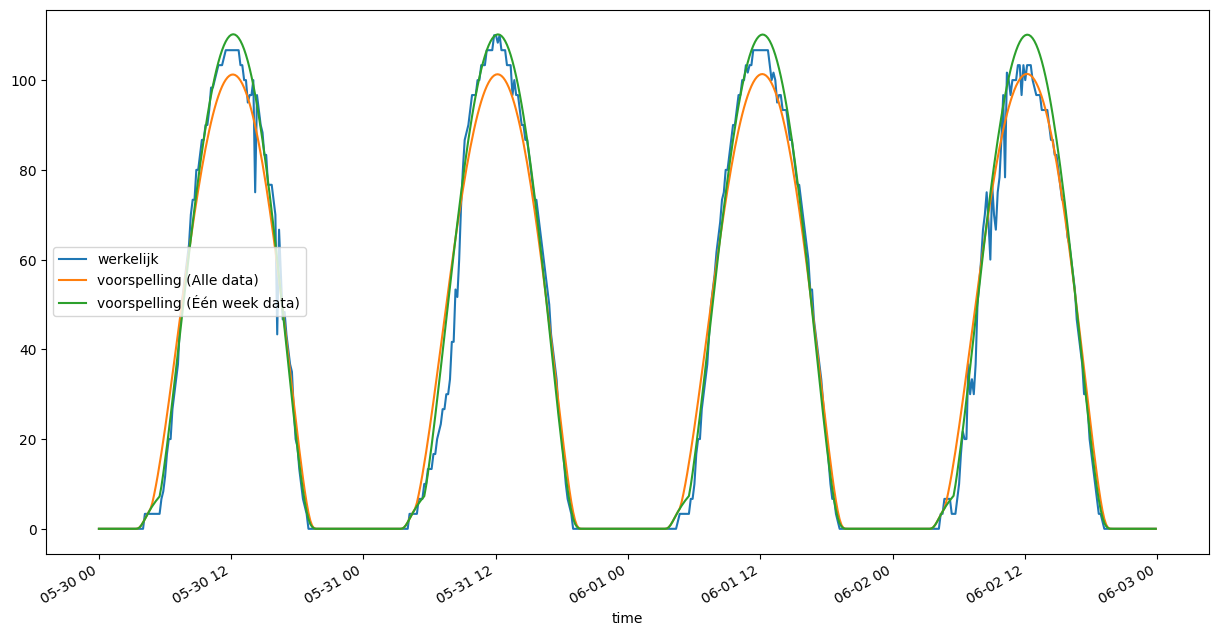

In [376]:
# Vergelijk de werkelijke productie met de voorspellingen
datetime_index = combined_df.loc['05-30-2021':'06-02-2021']
predictions_all = model_paneel(optimization_result_all3.x[0], optimization_result_all3.x[1], optimization_result_all3.x[2], datetime_index.index, lat, lon)
predictions_week = model_paneel(optimization_result_week3.x[0], optimization_result_week3.x[1], optimization_result_week3.x[2], datetime_index.index, lat, lon)

result_df = pd.DataFrame({
    'werkelijk': datetime_index['production'],
    'voorspelling (Alle data)': predictions_all['zonlicht'],
    'voorspelling (Één week data)': predictions_week['zonlicht']
})

# Visualiseer de vergelijkingen
temp_result = result_df.plot(figsize=(15,8))

## Observaties
- **Efficiëntie:** De efficiëntie van de zonnepanelen blijft vrij consistent bij `11.5%` tot `11.6%` over de verschillende niveaus van bewolking, zowel voor de hele dataset als voor een week.

### Tilt en Azimuth:

- **Hele Dataset:** Het ideale tilt- en azimuthhoek varieert met het toenemen van de bewolking, waarbij de tilt iets afneemt en de azimuth verandert om de efficiëntie te optimaliseren.
- **Enkele Week:** Bij het analyseren van een kortere periode (één week) blijken de tilt- en azimuthinstellingen veel groter en consistenter. Dit kan wijzen op seizoensgebonden of kortetermijnvariaties in de zonne-energieproductie die niet zichtbaar zijn in de hele dataset.

## Conclusie
Na het analyseren van de gegevens, merk ik dat er een klein verschil is tussen het bekijken van data op weekbasis en over de gehele dataset.

- **Op weekbasis** zie ik dat de voorspelling vaak __boven de werkelijkheid__ zit, maar over het algemeen zit hij vrij dichtbij.
- **Bij gebruik van de gehele dataset** zie ik dat hij vaak net wat __onder de werkelijkheid__ zit, maar ook deze zit over het algemeen vrij dichtbij.

------------

## Uitdaging - Seizoenen

In [382]:
# Functie om data voor een seizoen te filteren
def filter_seasonal_data(data, season):
    if season == 'Winter':
        return data.loc[(data.index.month == 12) | (data.index.month <= 2)]
    elif season == 'Lente':
        return data.loc[(data.index.month >= 3) & (data.index.month <= 5)]
    elif season == 'Zomer':
        return data.loc[(data.index.month >= 6) & (data.index.month <= 8)]
    elif season == 'Herfst':
        return data.loc[(data.index.month >= 9) & (data.index.month <= 11)]

# Filter data voor elk seizoen
seasonal_data_winter = filter_seasonal_data(combined_df, 'Winter')
seasonal_data_spring = filter_seasonal_data(combined_df, 'Lente')
seasonal_data_summer = filter_seasonal_data(combined_df, 'Zomer')
seasonal_data_fall = filter_seasonal_data(combined_df, 'Herfst')

In [383]:
# Groepeer de data op seizoen en bereken gemiddelde productie
seasonal_avg_production = solar_df.groupby('season')['production'].mean()

# Groepeer op seizoen en bereken standaarddeviatie van de productie (voor schaduwindicatie)
seasonal_std_production = solar_df.groupby('season')['production'].std()

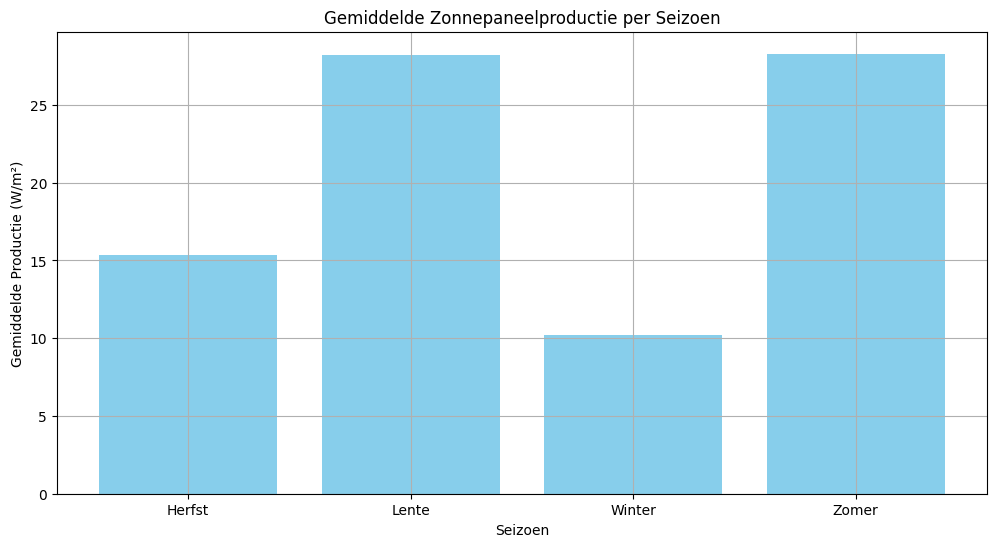

In [388]:
import matplotlib.pyplot as plt

# Plot gemiddelde productie per seizoen
plt.figure(figsize=(12, 6))
plt.bar(seasonal_avg_production.index, seasonal_avg_production.values, color='skyblue') # type: ignore
plt.xlabel('Seizoen')
plt.ylabel('Gemiddelde Productie (W/m²)')
plt.title('Gemiddelde Zonnepaneelproductie per Seizoen')
plt.grid(True)
plt.show()

In [385]:
# Optimalisatie voor elk seizoen
optimization_result_winter = minimize(loss, (tilt, azimuth, efficientie), args=(seasonal_data_winter, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_spring = minimize(loss, (tilt, azimuth, efficientie), args=(seasonal_data_spring, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_summer = minimize(loss, (tilt, azimuth, efficientie), args=(seasonal_data_summer, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
optimization_result_fall = minimize(loss, (tilt, azimuth, efficientie), args=(seasonal_data_fall, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))

In [386]:
# Toon de resultaten
display(Markdown("### Resultaten voor de dataset tijdens de Winter"))
print("Tilt:        {0:.1f}°".format(optimization_result_winter.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_winter.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_winter.x[2]*100))

display(Markdown("### Resultaten voor de dataset tijdens de Lente"))
print("Tilt:        {0:.1f}°".format(optimization_result_spring.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_spring.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_spring.x[2]*100))

display(Markdown("### Resultaten voor de dataset tijdens de Zomer"))
print("Tilt:        {0:.1f}°".format(optimization_result_summer.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_summer.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_summer.x[2]*100))

display(Markdown("### Resultaten voor de dataset tijdens de Herfst"))
print("Tilt:        {0:.1f}°".format(optimization_result_fall.x[0]))
print("Azimuth:     {0:.1f}°".format(optimization_result_fall.x[1]))
print("Efficiëntie: {0:.1f}%".format(optimization_result_fall.x[2]*100))

### Resultaten voor de dataset tijdens de Winter

Tilt:        1.7°
Azimuth:     90.0°
Efficiëntie: 5.9%


### Resultaten voor de dataset tijdens de Lente

Tilt:        14.1°
Azimuth:     201.4°
Efficiëntie: 7.6%


### Resultaten voor de dataset tijdens de Zomer

Tilt:        24.0°
Azimuth:     198.5°
Efficiëntie: 7.4%


### Resultaten voor de dataset tijdens de Herfst

Tilt:        1.9°
Azimuth:     270.0°
Efficiëntie: 7.9%
